In [57]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


In [58]:
k = 0.0001
phi = 0.2
cb = 0.15
lambd_nb = 1.8
mi_n = 0.2
lambd_bn = 0.1
y_n = 0.1
t_dom = (0, 10)
C_nmax = 0.55

size_t = int(((t_dom[1] - t_dom[0]) / (k)))

print(
    "Steps in time = {:d}\n".format(
        size_t,
    )
)

t = torch.arange(t_dom[0], t_dom[1], k, requires_grad=True).reshape(-1, 1)

t_numpy = t.cpu().detach().numpy()

Steps in time = 100000



In [59]:
from edo_fdm_model import solve_pde
import time

In [60]:
start_fdm = time.time()

Cp, Cl = solve_pde(
    k,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    t_numpy,
    C_nmax,
    size_t,
)

end_fdm = time.time()

In [61]:
time_fdm = end_fdm - start_fdm
time_fdm

0.05054068565368652

In [62]:
numpy_input = np.array([Cl, Cp]).T

if torch.cuda.is_available():
    device = torch.device("cuda")
    t = t.to(device)
    data_input = torch.tensor(numpy_input, dtype=torch.float32).to(device)

    print(device)

cuda


In [63]:
model = nn.Sequential(
    nn.Linear(1, 16),
    nn.Tanh(),
    nn.Linear(16, 16),
    nn.Tanh(),
    nn.Linear(16, 16),
    nn.Tanh(),
    nn.Linear(16, 16),
    nn.Tanh(),
    nn.Linear(16, 2),
).to(device)

print(model)

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=16, bias=True)
  (5): Tanh()
  (6): Linear(in_features=16, out_features=16, bias=True)
  (7): Tanh()
  (8): Linear(in_features=16, out_features=2, bias=True)
)


In [64]:
def initial_condition(t):
    Cl = torch.zeros_like(t)
    Cp = torch.zeros_like(t) + 0.2
    return torch.cat([Cl, Cp], dim=1)

In [65]:
def pde(t, model):

    Cl, Cp = model(t).split(1, dim=1)

    # Calculando Cp

    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    Cp_eq = (cb - lambd_nb * Cl) * Cp * phi - dCp_dt

    # Calculando Cl

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    Cl_eq = (y_n * Cp * (C_nmax - 1) - (lambd_bn * Cp + mi_n)) * Cl * phi - dCl_dt

    del dCl_dt
    del dCp_dt

    torch.cuda.empty_cache()

    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [66]:
loss_fn = nn.MSELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)
decay_rate = 0.99

lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

n_epochs = 500
batch_size = 100
C_pde_loss_it = torch.zeros(n_epochs).to(device)
C_data_loss_it = torch.zeros(n_epochs).to(device)
C_initial_loss_it = torch.zeros(n_epochs).to(device)
C_initial = initial_condition(t).to(device)

for epoch in range(n_epochs):
    for i in range(0, len(t), batch_size):

        t_initial = torch.zeros_like(t[i : i + batch_size])

        C_initial_pred = model(t_initial)

        loss_initial = loss_fn(C_initial[i : i + batch_size], C_initial_pred)

        C_pred = model(t[i : i + batch_size])

        loss_pde = loss_fn(
            pde(t[i : i + batch_size], model), torch.cat([t_initial, t_initial], dim=1)
        )

        loss_data = loss_fn(C_pred, data_input[i : i + batch_size])

        loss = loss_initial + loss_pde + loss_data
        # loss = loss_initial + loss_data

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # lr_scheduler.step()

    C_pde_loss_it[epoch] = loss_pde.item()
    C_initial_loss_it[epoch] = loss_initial.item()
    C_data_loss_it[epoch] = loss_data.item()

    if epoch % 100 == 0:
        print(f"Finished epoch {epoch}, latest loss {loss}")

Finished epoch 0, latest loss 4.541069245078688e-07
Finished epoch 100, latest loss 2.6928297302220017e-05
Finished epoch 200, latest loss 9.446114745514933e-06
Finished epoch 300, latest loss 9.602709724276792e-06
Finished epoch 400, latest loss 9.47786247706972e-06


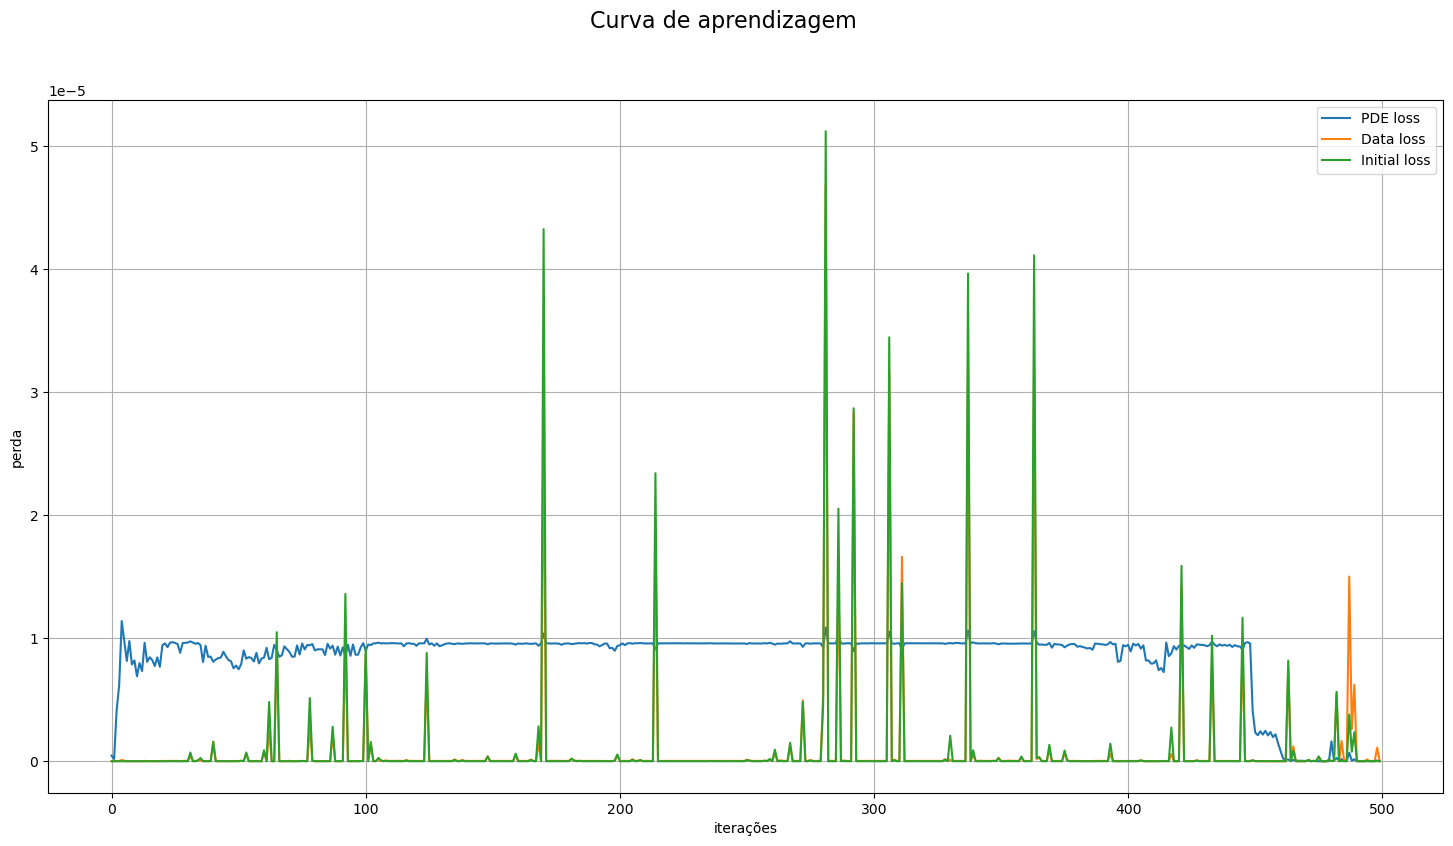

In [67]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle('Curva de aprendizagem', fontsize=16)


# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(range(len(C_pde_loss_it.cpu().numpy())),C_pde_loss_it.cpu().numpy(),label="PDE loss")
ax.plot(range(len(C_data_loss_it.cpu().numpy())),C_data_loss_it.cpu().numpy(),label="Data loss")
ax.plot(range(len(C_initial_loss_it.cpu().numpy())),C_initial_loss_it.cpu().numpy(),label="Initial loss")
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

In [68]:
start = time.time()

with torch.no_grad():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        t = t.to(device)
        
    Cl,Cp = model(t).split(1,dim=1)

end = time.time()

In [69]:
pinn_time = end-start
pinn_time

0.0005004405975341797

In [70]:
speed_up = time_fdm/pinn_time
speed_up

100.99237732253454

In [71]:
Cl = Cl.cpu().detach().numpy()
Cp = Cp.cpu().detach().numpy()


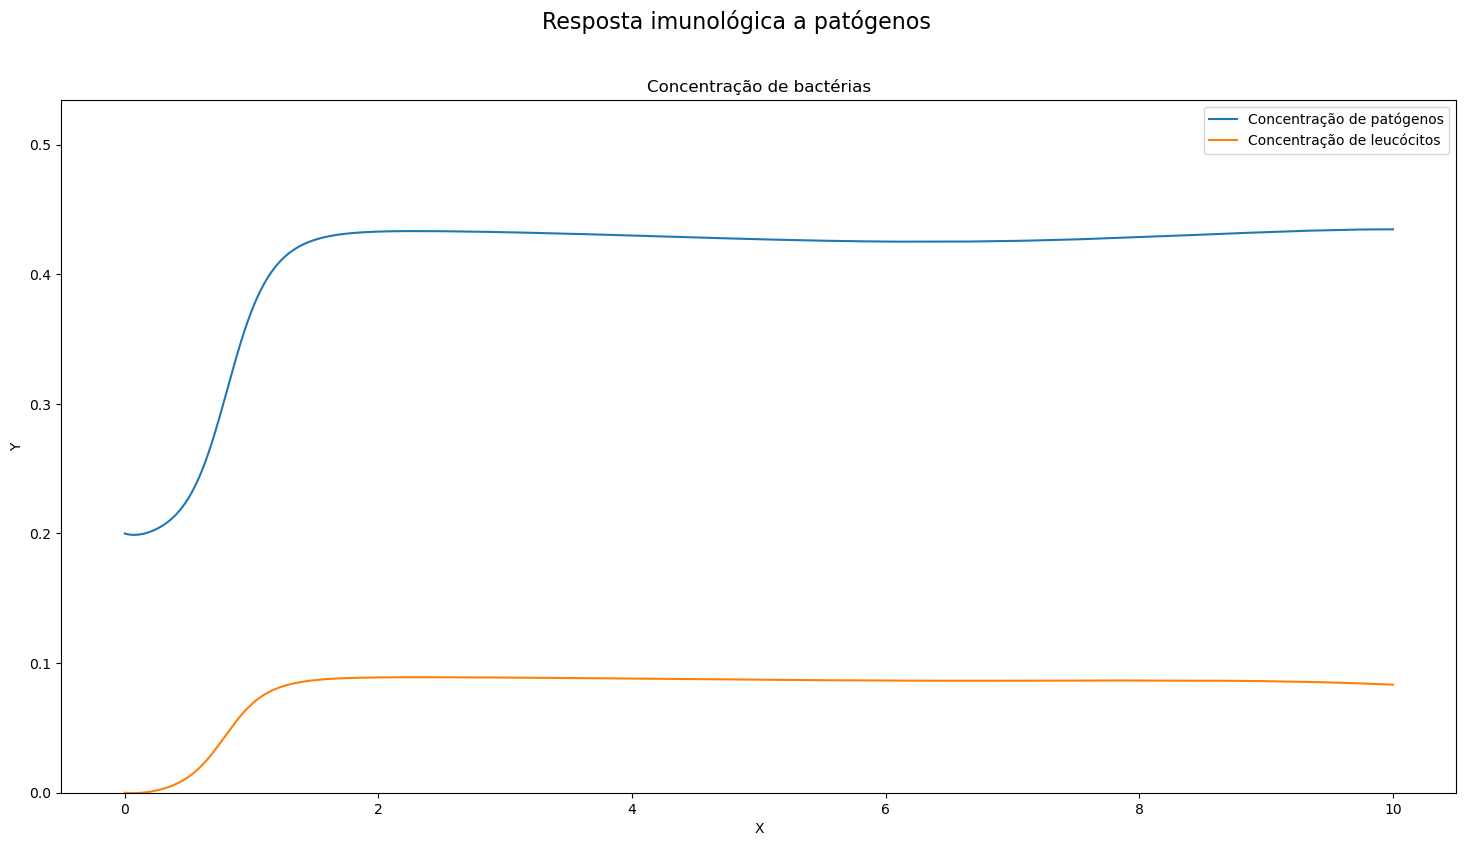

In [72]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)


vmin = 0
vmax = np.max([np.max(Cl), np.max(Cp)])

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.plot(t.cpu().detach().numpy(), Cp, label="Concentração de patógenos")
ax.plot(t.cpu().detach().numpy(), Cl, label="Concentração de leucócitos")
ax.set_title("Concentração de bactérias")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_ylim(vmin, vmax+0.1)
ax.legend()
plt.show()